In [ ]:
# The purpose of this file is to try ensemble models/classification for Diabetes Endotypes 
# created by Zhongyu Li, May 2024 
# Note: we will only use 6 cohort with HOMA2IR and HOMA2B data

In [1]:
# load libraries
import pandas as pd 
import numpy as np
import os as os

import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV


In [6]:
os. getlogin()

'root'

In [ ]:
#not working, need to figure out why as of 5.12.24 
os. getlogin()

if os.getlogin()=="JVARGH7":
    path_folder = 'C:/Cloud/Emory University/li, zhongyu - Diabetes Endotypes Project (JV and ZL)'
if os.getlogin()=="zhongyuli":
    path_folder = '/Users/zhongyuli/Library/CloudStorage/OneDrive-EmoryUniversity/Diabetes Endotypes Project (JV and ZL)'

# Rename the dataset into analytic sample
analytic_dataset = pd.read_csv(path_folder + '/working/processed/final_dataset.csv')


In [12]:
# first, we will load the data and conduct k means clustering to create the "TRUE labels"
# we will use the HOMA2IR and HOMA2B data to create the labels
# we will use the first 6 cohorts


path = '/Users/zhongyuli/Desktop/python/cluster analysis/dataset/final_dataset.csv'

analytic_dataset = pd.read_csv(path) 

#drop missing values
method3_df = analytic_dataset[analytic_dataset['method3'] == 1]

#select variables 
selected_variables = ['bmi', 'hba1c', 'dmagediag','homa2b','homa2ir','tgl','ldlc','ratio_th','sbp','dbp','hdlc']
#drop missing values in the selected variables
method3_df = method3_df[selected_variables]
method3_df = method3_df.dropna()

#check the data
method3_df.head()



,bmi,hba1c,dmagediag,homa2b,homa2ir,tgl,ldlc,ratio_th,sbp,dbp,hdlc
2106,37.39471,6.7,57.0,1250.5,12.345679,104,84.0,2.311111,132.66667,67.33333,45.0
2107,34.68809,5.6,70.0,911.0,20.408163,112,114.0,3.200000,154.00000,92.00000,35.0
2108,31.46388,7.6,75.0,881.1,16.393443,122,134.0,2.652174,138.33333,69.66667,46.0
2109,26.47712,6.8,87.0,766.7,8.264463,168,56.0,3.818182,117.66667,54.33333,44.0
2110,35.34697,6.1,73.0,673.5,13.888889,92,94.0,1.672727,141.00000,69.00000,55.0


In [13]:
method3_df.shape

(3201, 11)

In [14]:
# check if there are any missing values
method3_df.isnull().sum()
# check variable types
method3_df.dtypes



bmi          float64
hba1c        float64
dmagediag    float64
homa2b       float64
homa2ir      float64
tgl            int64
ldlc         float64
ratio_th     float64
sbp          float64
dbp          float64
hdlc         float64
dtype: object

In [17]:
#run kmeans clustering
#standardize the data
scaler = StandardScaler()
method3_df_scaled = scaler.fit_transform(method3_df)

method3_df_scaled = pd.DataFrame(method3_df_scaled, columns=method3_df.columns)



In [18]:
method3_df_scaled.head()

,bmi,hba1c,dmagediag,homa2b,homa2ir,tgl,ldlc,ratio_th,sbp,dbp,hdlc
0,0.554679,0.324154,-0.349968,13.182062,3.156100,-0.515797,-0.723383,-0.430527,0.446682,-0.522093,-0.162823
1,0.171496,-0.812598,0.643570,9.198821,6.074901,-0.424758,0.140179,-0.133499,1.609660,1.089272,-0.944319
2,-0.284964,1.254224,1.025701,8.848014,4.621482,-0.310958,0.715887,-0.316559,0.755597,-0.369666,-0.084673
3,-0.990953,0.427495,1.942813,7.505797,1.678608,0.212517,-1.529375,0.073071,-0.371038,-1.371326,-0.240972
4,0.264775,-0.295893,0.872849,6.412312,3.714777,-0.652356,-0.435529,-0.643848,0.900970,-0.413217,0.618674


In [19]:
# run kmeans and get cluster labels from the five variable method (method 3)
kmeans = KMeans(
    init="random", n_clusters=4, n_init=10, max_iter=300, random_state=57
)

# select five variables to cluster
var_m3 = ['bmi', 'hba1c', 'dmagediag','homa2b','homa2ir']
cluster_m3 = method3_df_scaled[var_m3]

kmeans = KMeans(init="random", n_clusters=4, n_init=10, max_iter=300, random_state=57)
kmeans.fit(cluster_m3)

KMeans(init='random', n_clusters=4, n_init=10, random_state=57)

In [21]:
# summarize the cluster labels 
method3_df['cluster'] = kmeans.labels_
method3_df['cluster'].value_counts()


cluster
2    1479
0    1311
1     278
3     133
Name: count, dtype: int64

In [25]:
# remane the cluster labels
method3_df['cluster'] = method3_df['cluster'].replace({0: 'MOD', 1: 'SIRD', 2: 'MARD', 3: 'SIDD'})
method3_df['cluster'].value_counts()
#summarize variables by cluster
method3_df.groupby('cluster').mean()

,bmi,hba1c,dmagediag,homa2b,homa2ir,tgl,ldlc,ratio_th,sbp,dbp,hdlc
cluster,,,,,,,,,,,
MARD,29.369065,6.145030,70.949620,88.007505,2.156878,136.498986,103.832454,3.053788,126.987878,70.376148,49.733874
MOD,37.897690,6.312304,51.008597,136.291228,4.005769,161.395881,116.464989,4.100154,121.772548,81.032541,44.269870
SIDD,35.051995,9.692481,52.957565,61.986466,3.545542,160.804511,111.992481,4.073117,120.390099,82.586274,45.105263
SIRD,33.727952,6.437410,65.700768,321.332374,9.709215,155.147482,101.356115,3.915294,125.780245,71.269633,47.197842


In [77]:
# run random forest model
# select the variables
var_m4 = ['bmi', 'hba1c', 'dmagediag','tgl','ldlc','ratio_th','sbp','dbp','hdlc']
X = method3_df[var_m4]
y = method3_df['cluster']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)

# run random forest model
rf = RandomForestClassifier(random_state=57, class_weight='balanced') 
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# check the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8455538221528861


In [78]:
# obtain the accuracy of the model by each cluster 
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        MARD       0.84      0.96      0.89       301
         MOD       0.86      0.91      0.88       249
        SIDD       0.90      0.93      0.91        28
        SIRD       0.33      0.02      0.03        63

    accuracy                           0.85       641
   macro avg       0.73      0.70      0.68       641
weighted avg       0.80      0.85      0.81       641



In [ ]:
# Model tuning
# define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_samples': [0.5, 0.7, 0.9]
}

# run grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)






In [80]:
# summarize the results 
grid_search.best_score_
# get the accuracy of the best model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# get the best parameters
grid_search.best_params_



Accuracy: 0.8486739469578783


{'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

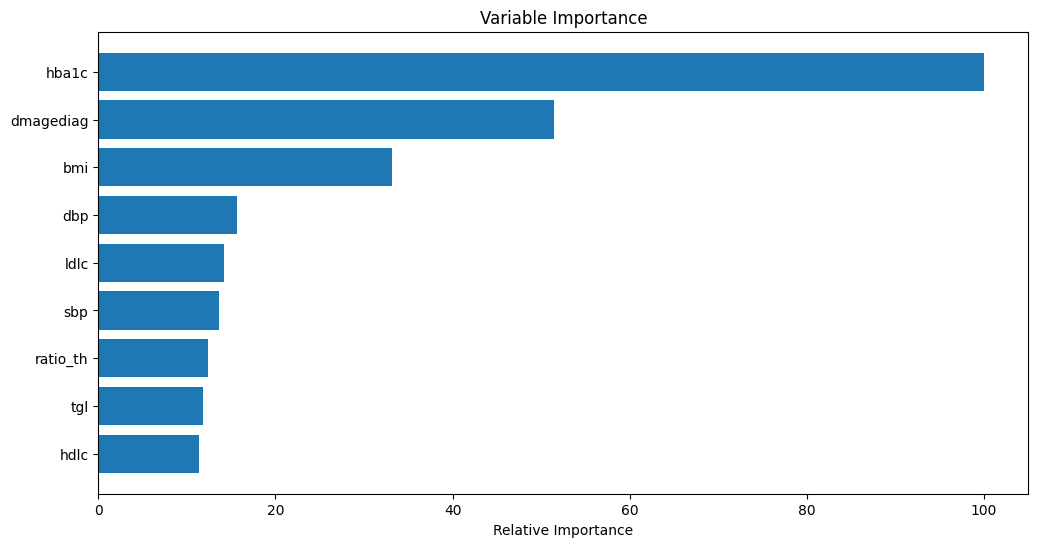

In [81]:
# get the feature importance
feature_importance = best_rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


The contribution of age, hba1c, and bmi to the classficiation results is very substantial compared with other six variables. This may explain the misclassfication of SIRD to MOD and MARD. 

In [82]:
# get the classification report 
print(classification_report(y_test, y_pred))
# improvement after tuning the model was slightly improvded 

              precision    recall  f1-score   support

        MARD       0.84      0.95      0.89       301
         MOD       0.86      0.92      0.89       249
        SIDD       0.87      0.96      0.92        28
        SIRD       0.50      0.02      0.03        63

    accuracy                           0.85       641
   macro avg       0.77      0.71      0.68       641
weighted avg       0.82      0.85      0.81       641



### Summary of the RF model after tunning 
1. precision: true positive/(true positive + false positive), very low for SIRD 
2. Recall: the ability of a model to find all actual positive cases, very low for SIRD, the model failed to find most of the actual SIRD 
3. F1 score: the weighted average of the precison and recall, taking both false positives and false negatives into account. very low for SIRD
4. The number of actual occurences of the class in the dataset. 
5. macro avg: average of precision, recall, and F1 score across all classes, label imbalance not taken into account 
6. Weight avg: label imbalance was taken into account by weighting the score of each class by the number of true instances. Macro vs. Weighted Metrics: The weighted averages are higher than the macro averages, indicating that the model performs well on larger classes but struggles with smaller/more complex classes. Addressing the balance and tuning based on class-specific metrics can be beneficial.

In [86]:
# describe the inccorectly classified samples
incorrect = y_test != y_pred
incorrect_samples = X_test[incorrect]
incorrect_samples['true_label'] = y_test[incorrect]
incorrect_samples['predicted_label'] = y_pred[incorrect]
incorrect_samples.head()

# summarize the incorrectly classified samples and compare the true and predicted labels

incorrect_samples.groupby(['true_label', 'predicted_label']).mean()





/var/folders/mw/svm2x9qn5fx658rhfzs94mxh0000gn/T/ipykernel_4311/412931879.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect_samples['true_label'] = y_test[incorrect]
/var/folders/mw/svm2x9qn5fx658rhfzs94mxh0000gn/T/ipykernel_4311/412931879.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect_samples['predicted_label'] = y_pred[incorrect]


bmi     hba1c  dmagediag         tgl  \
true_label predicted_label                                               
MARD       MOD              31.248465  6.192308  55.747313  226.076923   
           SIRD             34.008450  6.500000  64.479450   99.000000   
MOD        MARD             33.407556  6.350000  62.380547  172.550000   
SIDD       MOD              31.489940  7.900000  52.000000  131.000000   
SIRD       MARD             31.020701  6.414706  71.245850  144.176471   
           MOD              40.717700  6.145833  58.704451  181.166667   
           SIDD             32.986187  8.700000  72.000000  134.250000   

                                  ldlc  ratio_th         sbp         dbp  \
true_label predicted_label                                                 
MARD       MOD              107.461538  5.266358  109.153846   85.333333   
           SIRD              95.000000  2.414634  113.000000   72.000000   
MOD        MARD             111.400000  3.952063  125.700000   74.766667   
SIDD       MOD              178.000000  2.519231   74.666670  112.333330   
SIRD       MARD              93.411765  3.399897  128.509804   69.147059   
           MOD              107.041667  4.988093  120.232370   72.982097   
           SIDD              90.250000  3.077194  124.583332   65.166668   

                                 hdlc  
true_label predicted_label             
MARD       MOD              47.000000  
           SIRD             41.000000  
MOD        MARD             46.600000  
SIDD       MOD              52.000000  
SIRD       MARD             46.000000  
           MOD              42.708333  
           SIDD             47.750000

In [87]:
incorrect_samples.groupby(['true_label', 'predicted_label']).size()

true_label  predicted_label
MARD        MOD                13
            SIRD                1
MOD         MARD               20
SIDD        MOD                 1
SIRD        MARD               34
            MOD                24
            SIDD                4
dtype: int64

In [88]:
# summarize the both corrent and incorrect samples
X_test['true_label'] = y_test
X_test['predicted_label'] = y_pred
X_test['correct'] = X_test['true_label'] == X_test['predicted_label']
X_test.groupby(['true_label', 'predicted_label', 'correct']).mean()


bmi     hba1c  dmagediag  \
true_label predicted_label correct                                   
MARD       MARD            True     29.285789  6.120557  72.161586   
           MOD             False    31.248465  6.192308  55.747313   
           SIRD            False    34.008450  6.500000  64.479450   
MOD        MARD            False    33.407556  6.350000  62.380547   
           MOD             True     38.498711  6.275546  51.333780   
SIDD       MOD             False    31.489940  7.900000  52.000000   
           SIDD            True     35.012666  9.666667  51.631964   
SIRD       MARD            False    31.020701  6.414706  71.245850   
           MOD             False    40.717700  6.145833  58.704451   
           SIDD            False    32.986187  8.700000  72.000000   
           SIRD            True     35.516580  6.700000  62.000000   

                                           tgl        ldlc  ratio_th  \
true_label predicted_label correct                                     
MARD       MARD            True     133.644599  103.039373  3.031128   
           MOD             False    226.076923  107.461538  5.266358   
           SIRD            False     99.000000   95.000000  2.414634   
MOD        MARD            False    172.550000  111.400000  3.952063   
           MOD             True     163.467249  113.842795  4.085714   
SIDD       MOD             False    131.000000  178.000000  2.519231   
           SIDD            True     165.222222  111.518519  4.285680   
SIRD       MARD            False    144.176471   93.411765  3.399897   
           MOD             False    181.166667  107.041667  4.988093   
           SIDD            False    134.250000   90.250000  3.077194   
           SIRD            True      62.000000  131.000000  1.675676   

                                           sbp         dbp       hdlc  
true_label predicted_label correct                                     
MARD       MARD            True     128.239246   68.732051  49.261324  
           MOD             False    109.153846   85.333333  47.000000  
           SIRD            False    113.000000   72.000000  41.000000  
MOD        MARD            False    125.700000   74.766667  46.600000  
           MOD             True     120.458154   80.278731  44.803493  
SIDD       MOD             False     74.666670  112.333330  52.000000  
           SIDD            True     113.839142   86.680894  44.518519  
SIRD       MARD            False    128.509804   69.147059  46.000000  
           MOD             False    120.232370   72.982097  42.708333  
           SIDD            False    124.583332   65.166668  47.750000  
           SIRD            True     122.000000   58.666670  37.000000

In [89]:
X_test.groupby(['true_label', 'predicted_label', 'correct']).size()

true_label  predicted_label  correct
MARD        MARD             True       287
            MOD              False       13
            SIRD             False        1
MOD         MARD             False       20
            MOD              True       229
SIDD        MOD              False        1
            SIDD             True        27
SIRD        MARD             False       34
            MOD              False       24
            SIDD             False        4
            SIRD             True         1
dtype: int64

### Try Resampling 

In [50]:
# pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)


In [66]:
smote = SMOTE(random_state=57)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)



In [67]:
rf = RandomForestClassifier(n_estimators=200, max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, criterion='entropy', max_samples=0.7, random_state=57)

rf.fit(X_resampled, y_resampled)


RandomForestClassifier(criterion='entropy', max_depth=20, max_samples=0.7,
                       n_estimators=200, random_state=57)

In [69]:
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8081123244929798
              precision    recall  f1-score   support

        MARD       0.88      0.86      0.87       301
         MOD       0.88      0.86      0.87       249
        SIDD       0.87      0.96      0.92        28
        SIRD       0.24      0.27      0.25        63

    accuracy                           0.81       641
   macro avg       0.72      0.74      0.73       641
weighted avg       0.82      0.81      0.81       641



In [ ]:
# run grid search
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
# grid_search.fit(X_resampled, y_resampled)

In [71]:
# summarize the results
grid_search.best_score_
# get the accuracy of the best model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# get the best parameters
grid_search.best_params_


Accuracy: 0.8081123244929798


{'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'max_depth': 30,
 'max_features': 'sqrt',
 'max_samples': 0.9,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

#### No improvements after resampling 

### Try combine RF and Gradient Boosting Machines (GBMs)

In [75]:
# FR and GBM models
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)

# Random Forest model, use the best parameters from the grid search
# rf = RandomForestClassifier(n_estimators=200, max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, criterion='entropy', class_weight='balanced_subsample', max_samples=0.7, random_state=57)

estimators = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, criterion='entropy', class_weight='balanced_subsample', max_samples=0.7, random_state=57)),
    ('gbm', GradientBoostingClassifier(n_estimators=100, random_state=57))
]

# Create the stacking model
stack_model = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(n_estimators=200, random_state=57), cv=5)

# Train the stacking model
stack_model.fit(X_train, y_train)

# Evaluate the model
score = stack_model.score(X_test, y_test)
print(f"Accuracy of stacked model: {score}")

Accuracy of stacked model: 0.84399375975039


In [76]:
# get the classification report
y_pred = stack_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        MARD       0.83      0.96      0.89       301
         MOD       0.86      0.90      0.88       249
        SIDD       0.87      0.96      0.92        28
        SIRD       0.50      0.02      0.03        63

    accuracy                           0.84       641
   macro avg       0.77      0.71      0.68       641
weighted avg       0.81      0.84      0.80       641



#### RF + GBM does not appear to improve the predictions either 